In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/adhd-data/adhd_combined_data2 (1).csv
/kaggle/input/adhd-data/adhd_combined_data1.csv
/kaggle/input/control-adhd/Control_data2.csv


# Read the separating dataset
* control children (df1) and ADHD children (df2)

In [2]:
df1=pd.read_csv("/kaggle/input/control-adhd/Control_data2.csv")
df2=pd.read_csv("/kaggle/input/adhd-data/adhd_combined_data1.csv")

In [3]:
print(f"the shape of df1 : {df1.shape}")
print(f"the shape of df2 : {df2.shape}")

the shape of df1 : (959314, 20)
the shape of df2 : (1207069, 20)


In [4]:
print(f"the null values in  df1 : \n{df1.isna().sum()}")
print(40*'_')
print(f"the null values in  df2 : \n{df2.isna().sum()}")

the null values in  df1 : 
Fp1            0
Fp2            0
F3             0
F4             0
C3             0
C4             0
P3             0
P4             0
O1             0
O2             0
F7             0
F8             0
T7             0
T8             0
P7             0
P8             0
Fz             0
Cz             0
Pz             0
source_file    0
dtype: int64
________________________________________
the null values in  df2 : 
Fp1            0
Fp2            0
F3             0
F4             0
C3             0
C4             0
P3             0
P4             0
O1             0
O2             0
F7             0
F8             0
T7             0
T8             0
P7             0
P8             0
Fz             0
Cz             0
Pz             0
source_file    0
dtype: int64


In [5]:
print(f"the duplicated values in df1 = {df1.duplicated().sum()}")
print(f"the duplicated values in df2 = {df2.duplicated().sum()}")

the duplicated values in df1 = 9
the duplicated values in df2 = 36


* I'll drop the source file column as it is not important and drop the duplicated values too 
( doing some cleaning)

In [6]:
df1.drop_duplicates(inplace=True)
df2.drop_duplicates(inplace=True)

In [7]:
df1.drop(['source_file'],axis=1,inplace=True)
df2.drop(['source_file'],axis=1,inplace=True)

# Functions for Preprocessing the EEG Signals

In [8]:
from scipy import signal
from scipy.stats import entropy
import networkx as nx
from sklearn.preprocessing import StandardScaler

def extract_structural_features(eeg_data):
    """
    Extract structural features using Graph Signal Processing (GSP)
    """
    features = {}
    
    # Calculate power spectral density for different frequency bands
    fs = 128  # Assuming sampling frequency of 128 Hz - adjust if different
    for column in eeg_data.columns:
        # Get the signal
        sig = eeg_data[column].values
        
        # Calculate frequency bands using Welch's method
        freqs, psd = signal.welch(sig, fs, nperseg=256)
        
        # Define frequency bands
        delta_idx = np.logical_and(freqs >= 0.5, freqs <= 4)
        theta_idx = np.logical_and(freqs >= 4, freqs <= 8)
        alpha_idx = np.logical_and(freqs >= 8, freqs <= 13)
        beta_idx = np.logical_and(freqs >= 13, freqs <= 30)
        
        # Calculate band powers
        features[f'{column}_delta'] = np.mean(psd[delta_idx])
        features[f'{column}_theta'] = np.mean(psd[theta_idx])
        features[f'{column}_alpha'] = np.mean(psd[alpha_idx])
        features[f'{column}_beta'] = np.mean(psd[beta_idx])
        
        # Add spectral entropy
        features[f'{column}_spectral_entropy'] = entropy(psd)
        
    return pd.Series(features)

In [9]:
def extract_functional_features(eeg_data):
    """
    Extract functional connectivity features from EEG data using correlation
    and graph theoretical measures.
    
    Parameters:
    -----------
    eeg_data : pandas.DataFrame
        DataFrame containing EEG data with channels as columns
        
    Returns:
    --------
    pandas.Series
        Series containing extracted functional features
    """
    features = {}
    
    # Calculate correlation matrix between channels
    corr_matrix = eeg_data.corr().values
    
    # Create weighted graph from correlation matrix
    G = nx.from_numpy_array(np.abs(corr_matrix))
    
    # Calculate graph theoretical measures
    
    # 1. Global efficiency
    features['global_efficiency'] = nx.global_efficiency(G)
    
    # 2. Average clustering coefficient
    features['clustering_coefficient'] = nx.average_clustering(G, weight='weight')
    
    # 3. Average node strength (weighted degree)
    node_strength = dict(nx.degree(G, weight='weight'))
    features['avg_node_strength'] = np.mean(list(node_strength.values()))
    
    # 4. Graph density
    features['graph_density'] = nx.density(G)
    
    # 5. Assortativity
    features['assortativity'] = nx.degree_assortativity_coefficient(G, weight='weight')
    
    # Calculate band-specific connectivity features
    fs = 128  # Sampling frequency
    for band_name, (low_freq, high_freq) in {
        'delta': (0.5, 4),
        'theta': (4, 8),
        'alpha': (8, 13),
        'beta': (13, 30)
    }.items():
        # Filter signal in specific band
        nyquist = fs / 2
        b, a = signal.butter(4, [low_freq/nyquist, high_freq/nyquist], btype='band')
        
        filtered_data = pd.DataFrame(
            signal.filtfilt(b, a, eeg_data.values, axis=0),
            columns=eeg_data.columns
        )
        
        # Calculate correlation matrix for filtered data
        band_corr = filtered_data.corr().values
        band_G = nx.from_numpy_array(np.abs(band_corr))
        
        # Extract band-specific graph measures
        features[f'{band_name}_global_efficiency'] = nx.global_efficiency(band_G)
        features[f'{band_name}_clustering'] = nx.average_clustering(band_G, weight='weight')
        
        # Calculate mean connectivity for each band
        features[f'{band_name}_mean_connectivity'] = np.mean(np.abs(band_corr[np.triu_indices_from(band_corr, k=1)]))
    
    # Add some statistical features of the correlation matrix
    upper_triangle = corr_matrix[np.triu_indices_from(corr_matrix, k=1)]
    features['mean_connectivity'] = np.mean(np.abs(upper_triangle))
    features['std_connectivity'] = np.std(np.abs(upper_triangle))
    features['max_connectivity'] = np.max(np.abs(upper_triangle))
    
    return pd.Series(features)

In [10]:
def process_eeg_dataframe(df):
    """
    Process a single EEG dataframe and extract all features
    """
    # Extract features for each window of data
    window_size = 256  # 2 seconds at 128 Hz
    stride = 128  # 50% overlap
    
    all_features = []
    
    for start in range(0, len(df) - window_size, stride):
        window = df.iloc[start:start + window_size]
        
        # Extract both types of features
        structural_features = extract_structural_features(window)
        functional_features = extract_functional_features(window)
        
        # Combine features
        combined_features = pd.concat([structural_features, functional_features])
        all_features.append(combined_features)
    
    # Combine all windows
    feature_df = pd.DataFrame(all_features)
    
    return pd.DataFrame(feature_df, columns=feature_df.columns)

## Process the data and add the label column that identify that the child has ADHD or not

In [12]:
print("Processing control group data...")
df1_processed = process_eeg_dataframe(df1)
df1_processed['target'] = 0  # Control group

print("Processing ADHD group data...")
df2_processed = process_eeg_dataframe(df2)
df2_processed['target'] = 1  # ADHD group

Processing control group data...
Processing ADHD group data...


## +Now concatenate the two data frames into one

In [13]:
combined_df = pd.concat([df1_processed, df2_processed], axis=0, ignore_index=True)

In [14]:
combined_df.head()

,Fp1_delta,Fp1_theta,Fp1_alpha,Fp1_beta,Fp1_spectral_entropy,Fp2_delta,Fp2_theta,Fp2_alpha,Fp2_beta,Fp2_spectral_entropy,...,alpha_global_efficiency,alpha_clustering,alpha_mean_connectivity,beta_global_efficiency,beta_clustering,beta_mean_connectivity,mean_connectivity,std_connectivity,max_connectivity,target
0,39888.645280,162.043932,121.706115,56.853991,1.045066,19661.903863,249.915808,162.809052,66.553625,1.047432,...,1.0,0.358781,0.419235,1.0,0.203254,0.260420,0.554413,0.259287,0.965446,0
1,14287.662414,555.815690,198.083797,90.355885,1.595079,12697.561354,590.898598,137.365185,59.409942,1.452581,...,1.0,0.304517,0.366649,1.0,0.200787,0.252937,0.534809,0.227544,0.969061,0
2,27373.535222,11541.305211,1300.377780,84.802595,2.851174,17179.788488,7042.396521,954.447418,77.024656,2.896441,...,1.0,0.288793,0.361628,1.0,0.232691,0.284192,0.475462,0.181746,0.947182,0
3,4842.895269,627.565334,218.581569,125.232223,2.805982,2030.352648,468.427953,156.230742,84.190239,3.121087,...,1.0,0.352341,0.419436,1.0,0.220754,0.270806,0.443793,0.198463,0.894352,0
4,5117.525282,753.568871,133.799676,109.601261,2.580247,1228.560910,351.092200,183.742949,86.171416,3.226684,...,1.0,0.305261,0.382747,1.0,0.221559,0.272386,0.455269,0.188575,0.888861,0


In [15]:
print("\nProcessed Dataset Information:")
print(f"Total number of samples: {len(combined_df)}")
print(f"Number of features: {combined_df.shape[1] - 1}")  # Excluding target column
print(f"Number of control samples: {len(df1_processed)}")
print(f"Number of ADHD samples: {len(df2_processed)}")
print(combined_df.shape)


Processed Dataset Information:
Total number of samples: 16921
Number of features: 115
Number of control samples: 7493
Number of ADHD samples: 9428
(16921, 116)


## shuffle the data because all the controls children are on the top of the data then the ADHD children

In [16]:
from sklearn.utils import shuffle
combined_df = shuffle(combined_df)

# Modeling

In [17]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

## Split the data

In [18]:
X = combined_df.drop('target', axis=1)
y = combined_df['target']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2,
    random_state=42,
    stratify=y
)


## Scale the data

In [19]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [20]:
params={'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}
svm = SVC(**params, random_state=42, probability=True)
svm.fit(X_train_scaled, y_train)
    
    # Make predictions
y_pred = svm.predict(X_test_scaled)

In [21]:
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.94      0.94      1499
           1       0.95      0.96      0.95      1886

    accuracy                           0.95      3385
   macro avg       0.95      0.95      0.95      3385
weighted avg       0.95      0.95      0.95      3385



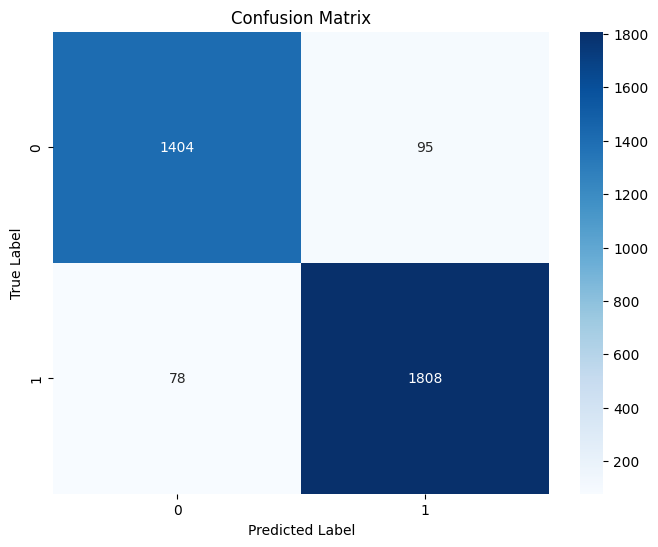

In [22]:
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [ ]:
print("\nBest parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

In [23]:
import numpy as np
import pandas as pd
from scipy import signal
from scipy.stats import entropy
import networkx as nx
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
import joblib

In [38]:
import numpy as np
import pandas as pd
from scipy import signal
from scipy.stats import entropy
import networkx as nx
from sklearn.base import BaseEstimator, TransformerMixin

class EEGFeatureExtractor(BaseEstimator, TransformerMixin):
    """
    A class for extracting both structural and functional features from EEG data.
    Implements sklearn's TransformerMixin for easy pipeline integration.
    
    Parameters:
    -----------
    sampling_freq : int, default=128
        Sampling frequency of the EEG data in Hz
    window_size : int, default=256
        Size of the window for feature extraction (in samples)
    stride : int, default=128
        Number of samples to move between windows (for overlapping windows)
    frequency_bands : dict, optional
        Dictionary of frequency bands to analyze. Default includes standard bands.
    """
    
    def __init__(self, sampling_freq=128, window_size=256, stride=128,
                 frequency_bands=None):
        self.sampling_freq = sampling_freq
        self.window_size = window_size
        self.stride = stride
        self.frequency_bands = frequency_bands or {
            'delta': (0.5, 4),
            'theta': (4, 8),
            'alpha': (8, 13),
            'beta': (13, 30)
        }
        
        # Validate initialization parameters
        if window_size < 256:
            raise ValueError("window_size must be at least 256 samples")
        if stride > window_size:
            raise ValueError("stride must be less than or equal to window_size")
            
    def _extract_structural_features(self, eeg_data):
        """Extract structural features using GSP"""
        features = {}
        
        for column in eeg_data.columns:
            sig = eeg_data[column].values
            
            # Calculate frequency bands using Welch's method
            freqs, psd = signal.welch(sig, self.sampling_freq, nperseg=256)
            
            # Calculate band powers for each frequency band
            for band_name, (low_freq, high_freq) in self.frequency_bands.items():
                band_idx = np.logical_and(freqs >= low_freq, freqs <= high_freq)
                features[f'{column}_{band_name}'] = np.mean(psd[band_idx])
            
            # Add spectral entropy
            features[f'{column}_spectral_entropy'] = entropy(psd)
            
        return pd.Series(features)
    
    def _extract_functional_features(self, eeg_data):
        """Extract functional connectivity features"""
        features = {}
        
        # Calculate correlation matrix between channels
        corr_matrix = eeg_data.corr().values
        
        # Create weighted graph from correlation matrix
        G = nx.from_numpy_array(np.abs(corr_matrix))
        
        # Calculate graph theoretical measures
        features['global_efficiency'] = nx.global_efficiency(G)
        features['clustering_coefficient'] = nx.average_clustering(G, weight='weight')
        features['graph_density'] = nx.density(G)
        features['assortativity'] = nx.degree_assortativity_coefficient(G, weight='weight')
        
        # Calculate node strength
        node_strength = dict(nx.degree(G, weight='weight'))
        features['avg_node_strength'] = np.mean(list(node_strength.values()))
        
        # Calculate band-specific connectivity features
        nyquist = self.sampling_freq / 2
        for band_name, (low_freq, high_freq) in self.frequency_bands.items():
            # Filter signal in specific band
            b, a = signal.butter(4, [low_freq/nyquist, high_freq/nyquist], btype='band')
            
            filtered_data = pd.DataFrame(
                signal.filtfilt(b, a, eeg_data.values, axis=0),
                columns=eeg_data.columns
            )
            
            # Calculate correlation matrix for filtered data
            band_corr = filtered_data.corr().values
            band_G = nx.from_numpy_array(np.abs(band_corr))
            
            # Extract band-specific graph measures
            features[f'{band_name}_global_efficiency'] = nx.global_efficiency(band_G)
            features[f'{band_name}_clustering'] = nx.average_clustering(band_G, weight='weight')
            features[f'{band_name}_mean_connectivity'] = np.mean(
                np.abs(band_corr[np.triu_indices_from(band_corr, k=1)])
            )
        
        # Add statistical features of the correlation matrix
        upper_triangle = corr_matrix[np.triu_indices_from(corr_matrix, k=1)]
        features['mean_connectivity'] = np.mean(np.abs(upper_triangle))
        features['std_connectivity'] = np.std(np.abs(upper_triangle))
        features['max_connectivity'] = np.max(np.abs(upper_triangle))
        
        return pd.Series(features)
    
    def fit(self, X, y=None):
        """Fit method (does nothing but is required for sklearn compatibility)"""
        return self
    
    def transform(self, X):
        """
        Transform the input EEG data into features.
        
        Parameters:
        -----------
        X : pandas.DataFrame or list of pandas.DataFrame
            Input EEG data. If a single DataFrame is provided, it will be processed
            as one continuous recording. If a list is provided, each DataFrame will
            be processed separately and the results will be concatenated.
            
        Returns:
        --------
        pandas.DataFrame
            Extracted features for each window of the input data
        """
        if not isinstance(X, (list, pd.DataFrame)):
            raise ValueError("Input must be a pandas DataFrame or list of DataFrames")
        
        # Convert single DataFrame to list for consistent processing
        if isinstance(X, pd.DataFrame):
            X = [X]
            
        all_features = []
        
        for df in X:
            # Process each window
            for start in range(0, len(df) - self.window_size + 1, self.stride):
                window = df.iloc[start:start + self.window_size]
                
                # Extract features
                structural_features = self._extract_structural_features(window)
                functional_features = self._extract_functional_features(window)
                
                # Combine features
                combined_features = pd.concat([structural_features, functional_features])
                all_features.append(combined_features)
        
        # Combine all windows and trials
        feature_df = pd.DataFrame(all_features)
        
        return feature_df

In [39]:
X_test_df

,Fp1,Fp2,F3,F4,C3,C4,P3,P4,O1,O2,F7,F8,T7,T8,P7,P8,Fz,Cz,Pz
0,-407,-19,126,226,126,126,89,126,236,-20,347,89,273,52,236,16,261,156,191
1,-477,-125,126,85,52,52,126,126,163,-20,163,16,273,52,236,16,156,15,226
2,-583,-55,89,50,16,16,52,89,52,-94,89,89,200,126,200,-57,226,50,191
3,-371,191,273,191,236,89,89,163,163,16,200,163,310,236,273,52,332,156,297
4,-477,121,236,191,236,126,200,163,126,163,89,163,347,200,200,126,332,156,297
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
379,226,85,310,156,236,126,126,236,126,347,310,89,126,89,163,236,332,191,226
380,297,121,273,191,236,89,163,126,89,200,-20,126,163,163,163,163,297,156,191
381,226,156,163,191,163,126,52,163,-20,163,52,163,89,200,89,163,261,226,121
382,332,226,200,226,200,200,-20,273,-20,236,273,89,126,89,126,200,226,226,156


In [40]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# First, let's get feature names that will be produced
# We'll do this by running a small sample through the feature extractor
feature_extractor = EEGFeatureExtractor(
    sampling_freq=128,
    window_size=256,
    stride=128
)

X_test_df = pd.read_csv("/kaggle/input/x-test-eeg/X_test.csv")

# Get a sample of data to see feature names
sample_features = feature_extractor.transform(X_test_df.iloc[:256])
feature_names = sample_features.columns.tolist()

# Check if feature names match what scaler was trained on
if hasattr(scaler, 'feature_names_in_'):
    print("Features expected by scaler:", scaler.feature_names_in_)
    print("Features produced by extractor:", feature_names)
    

Features expected by scaler: ['Fp1_delta' 'Fp1_theta' 'Fp1_alpha' 'Fp1_beta' 'Fp1_spectral_entropy'
 'Fp2_delta' 'Fp2_theta' 'Fp2_alpha' 'Fp2_beta' 'Fp2_spectral_entropy'
 'F3_delta' 'F3_theta' 'F3_alpha' 'F3_beta' 'F3_spectral_entropy'
 'F4_delta' 'F4_theta' 'F4_alpha' 'F4_beta' 'F4_spectral_entropy'
 'C3_delta' 'C3_theta' 'C3_alpha' 'C3_beta' 'C3_spectral_entropy'
 'C4_delta' 'C4_theta' 'C4_alpha' 'C4_beta' 'C4_spectral_entropy'
 'P3_delta' 'P3_theta' 'P3_alpha' 'P3_beta' 'P3_spectral_entropy'
 'P4_delta' 'P4_theta' 'P4_alpha' 'P4_beta' 'P4_spectral_entropy'
 'O1_delta' 'O1_theta' 'O1_alpha' 'O1_beta' 'O1_spectral_entropy'
 'O2_delta' 'O2_theta' 'O2_alpha' 'O2_beta' 'O2_spectral_entropy'
 'F7_delta' 'F7_theta' 'F7_alpha' 'F7_beta' 'F7_spectral_entropy'
 'F8_delta' 'F8_theta' 'F8_alpha' 'F8_beta' 'F8_spectral_entropy'
 'T7_delta' 'T7_theta' 'T7_alpha' 'T7_beta' 'T7_spectral_entropy'
 'T8_delta' 'T8_theta' 'T8_alpha' 'T8_beta' 'T8_spectral_entropy'
 'P7_delta' 'P7_theta' 'P7_alpha' 'P7

# Creating the pipeline Ensuring the data have the same order

In [41]:
# Add the FeatureAligner to ensure correct order
class FeatureAligner(BaseEstimator, TransformerMixin):
    def __init__(self, feature_names):
        self.feature_names = feature_names
        
    def fit(self, X, y=None):
        return self
        
    def transform(self, X):
        return X[self.feature_names]

# Create pipeline with feature alignment
pipeline = Pipeline([
    ('feature_extraction', feature_extractor),
    ('feature_aligner', FeatureAligner(scaler.feature_names_in_)),  # This ensures correct order
    ('scaling', scaler),
    ('model', svm)
])

# Now this should work
y_pred = pipeline.predict(X_test_df)

# Check if the pipeline work

In [42]:
y_pred

array([1, 1])

# Download the pipeline using for the API

In [43]:
import joblib

# Save the pipeline to a file
joblib.dump(pipeline, 'adhd_diagnostic_pipeline.joblib')
print("Pipeline saved successfully!")


Pipeline saved successfully!


# Test the pipeline

In [44]:
import joblib
import pandas as pd

# Load the pipeline
pipeline = joblib.load('adhd_diagnostic_pipeline.joblib')
print("Pipeline loaded successfully!")


Pipeline loaded successfully!


In [45]:
y_pred = pipeline.predict(X_test_df)

print("Predicted Output:", y_pred)

Predicted Output: [1 1]


# Thanks for reading hope you enjoyed and know something new from us :)